# Parametrized Sequences

In [1]:
import numpy as np
import pulser
from pulser import Pulse, Sequence, Register
from pulser.waveforms import RampWaveform, BlackmanWaveform, CompositeWaveform
from pulser.devices import Chadoq2

From simple sweeps to variational quantum algorithms, it is often the case that one wants to try out multiple pulse sequences that vary only in a few parameters. For this effect, the ability to make a `Sequence` **parametrized** was developed.

A parametrized `Sequence` can be used just like a "regular" `Sequence`, with a few key differences. Initialization and channel declaration, for example, don't change at all: 

In [2]:
reg = Register.square(2, prefix='q')
seq = Sequence(reg, Chadoq2)
seq.declare_channel('rydberg', 'rydberg_global')
seq.declare_channel('raman', 'raman_local')

## Variables and Parametrized Objects

The defining characteristic of a `Sequence` that is parametrized is its use of **variables**. These variables are declared within a `Sequence`, by calling:

In [3]:
Omega_max = seq.declare_variable('Omega_max')
ts = seq.declare_variable('ts', size=2, dtype=int)
last_target = seq.declare_variable('last_target', dtype=str)

The returned `Omega_max`, `ts` and `last_target` objects are of type `Variable`, and are defined by their name, size and data type. In this case, `Omega_max` is a variable of `size=1` and `dtype=float` (the default), `ts` is an array of two `int` values and `last_target` is a string.

These returned `Variable` objects support simple arithmetic operations (when applicable) and, when of `size > 1`, even item indexing. Take the following examples:

In [4]:
t_rise, t_fall = ts  # Unpacking is possible too
U = Omega_max / 2.3
delta_0 = -6 * U
delta_f = 2 * U
t_sweep = (delta_f - delta_0)/(2 * np.pi * 10) * 1000

Both the original `Variables` and the results of these operations serve as valid inputs for `Waveforms`, `Pulses` or `Sequence`-building instructions. We can take `Omega_max` as an argument for a waveform:

In [5]:
pi_wf = BlackmanWaveform.from_max_val(Omega_max, np.pi)

or use derived quantities, like `t_rise`, `t_fall`, `delta_0` and `delta_f`:

In [6]:
rise_wf = RampWaveform(t_rise, delta_0, delta_f)
fall_wf = RampWaveform(t_fall, delta_f, delta_0)
rise_fall_wf = CompositeWaveform(rise_wf, fall_wf)

These waveforms are *parametrized* objects, so usual attributes like `duration` or `samples` are not available, as they depend on the values of the underlying variables. Nonetheless, they can be used as regular waveforms when creating `Pulses`, which will consequently be *parametrized* too.

In [7]:
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)
rise_fall = Pulse.ConstantAmplitude(Omega_max, rise_fall_wf, 0)

## Constructing the Sequence

Upon initialization, a `Sequence` is, by default, not parametrized. We can check this by calling:

In [8]:
seq.is_parametrized()

False

While it is not parametrized, it is just a normal sequence. We can do the usual stuff, like targeting a local channel, adding regular pulses, or plotting the sequence:

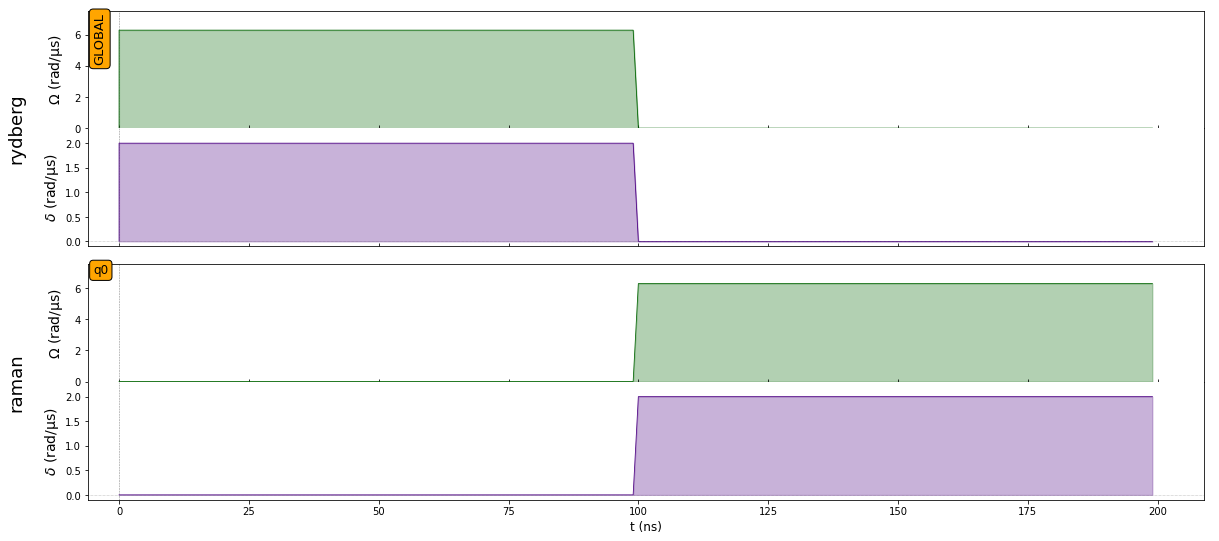

In [9]:
generic_pulse = Pulse.ConstantPulse(100, 2*np.pi, 2, 0.)
seq.add(generic_pulse, "rydberg")
seq.target("q0", "raman")
seq.add(generic_pulse, "raman")
seq.draw()

The `Sequence` becomes parametrized at the moment a parametrized object or variable is given to a sequence-building instruction. For example:

In [10]:
seq.target(last_target, "raman")
seq.is_parametrized()

True

From this point onward, functionalities like drawing are no longer available, because the instructions start being stored instead of executed on the fly. We can still check the current state of a parametrized sequence by printing it:

In [11]:
print(seq)

Prelude
-------
Channel: rydberg
t: 0 | Initial targets: q2, q1, q0, q3 | Phase Reference: 0.0 
t: 0->100 | Pulse(Amp=6.28 rad/µs, Detuning=2 rad/µs, Phase=0) | Targets: q2, q1, q0, q3

Channel: raman
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->200 | Pulse(Amp=6.28 rad/µs, Detuning=2 rad/µs, Phase=0) | Targets: q0

Stored calls
------------

1. target(last_target, raman)


Naturally, we can also add the parametrized pulses we previously created:

In [12]:
seq.add(rise_fall, "rydberg")
seq.add(pi_pulse, "raman")

## Building

Once we're happy with our parametrized sequence, the last step is to build it into a regular sequence. For that, we call the `Sequence.build()` method, in which we **must attribute values for all the declared variables**:

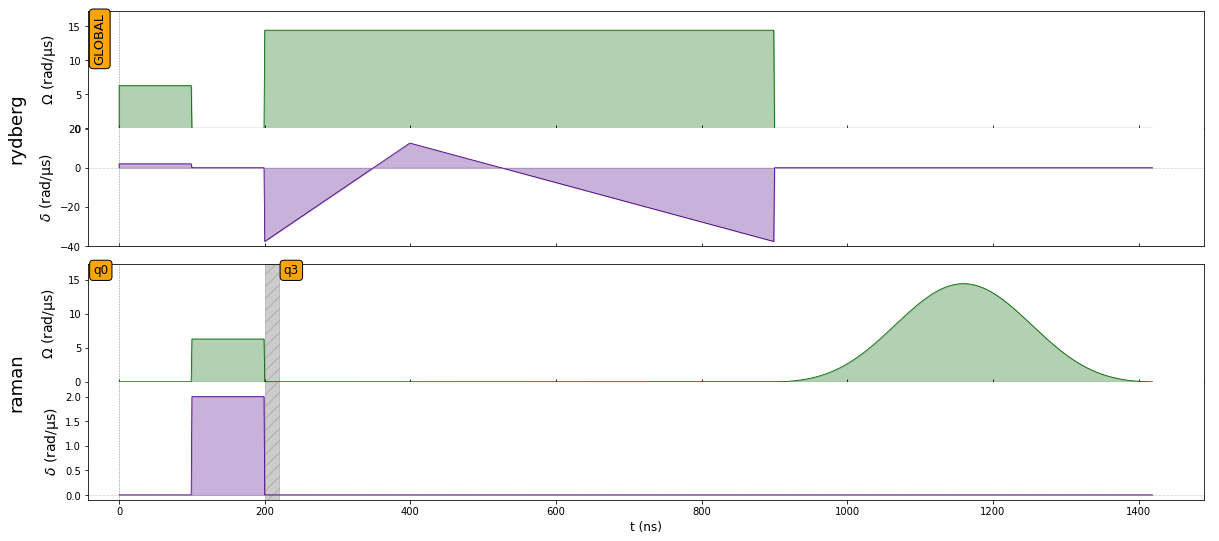

In [13]:
built_seq = seq.build(Omega_max = 2.3 * 2*np.pi,  ts = [200, 500], last_target="q3")
built_seq.draw()

And here we have a regular sequence, built from our parametrized sequence. To create a new one with different parameters, we can simply build it again with new values:

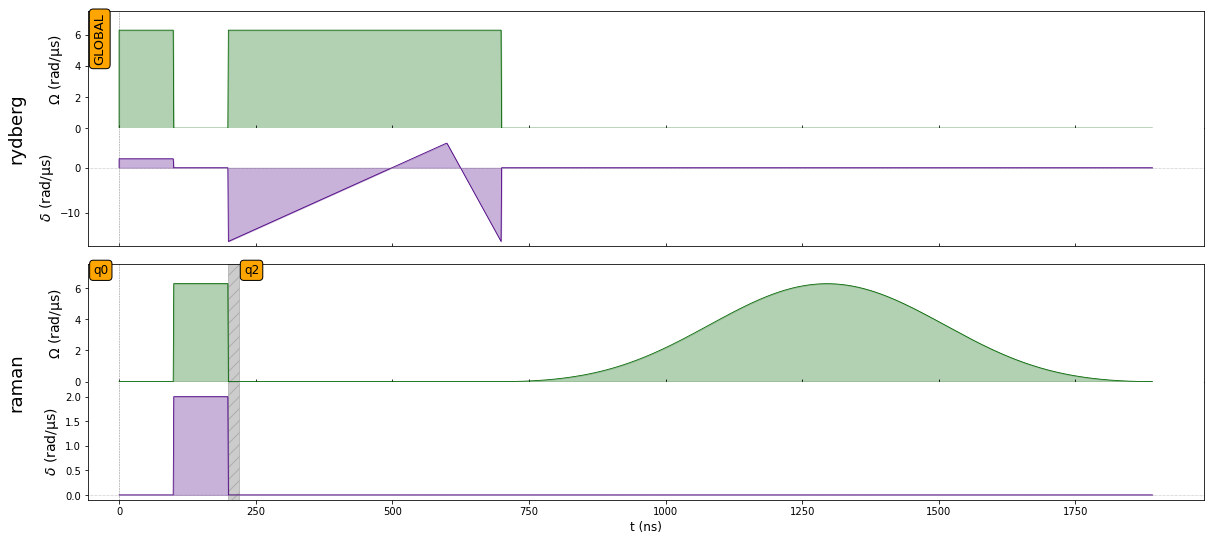

In [14]:
alt_seq = seq.build(Omega_max = 2*np.pi,  ts = [400, 100], last_target="q2")
alt_seq.draw()